In [1]:
import scanpy as sc
import scanpy.external as sce

import numpy as np
import pandas as pd

import pickle
import os
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

import plotnine as pn
import re

In [2]:
current_folder = globals()['_dh'][0]
cellbender_out = current_folder / ".." / ".." / "data" / "cellbender_out"
uscsc_out = current_folder / ".." / ".." / "data" / "uscsc_dump"
plot_out = current_folder / ".." / ".." / "out" / "cellbender_comparison"
plot_out.mkdir(parents=True, exist_ok=True)
sc._settings.ScanpyConfig.figdir = plot_out

In [3]:
samples = [sample for sample in os.listdir(cellbender_out) if not sample.startswith(".")]
adata_objects = {sample: sc.read_h5ad(cellbender_out / sample / "cell_bender_matrix_filtered_qc_annotated.h5ad") for sample in samples}
adata_objects_forced = {sample: sc.read_h5ad(cellbender_out / sample / "cell_bender_matrix_filtered_qc_annotated_forced.h5ad") for sample in samples}
adata_cellbender = sc.concat(list(adata_objects.values()), join="outer", label="sample_id", keys=list(adata_objects.keys()))
adata_cellbender_forced = sc.concat(list(adata_objects_forced.values()), join="outer", label="sample_id", keys=list(adata_objects_forced.keys()))
adata_cellbender

/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 76254 × 31227
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'diss_score', 'cell_type', 'sample_id'

In [4]:
adata_prev = sc.read_h5ad(uscsc_out / "annotated.h5ad")
adata_prev.obs.index = [re.sub("-[0-9]+$", "", barcode) for barcode in adata_prev.obs.index]
adata_prev

AnnData object with n_obs × n_vars = 69526 × 3000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'diss_score', 'patient_id', 'sample_id', 'lesion_type', 'spots_detected', 'total_genes', 'prop_reads_in_spots', 'median_genes', 'median_UMI', 'seq_saturation', 'rin', 'sex', 'age', 'duration_disease', 'batch', 'leiden', 'cell_type'
    var: 'highly_variable', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

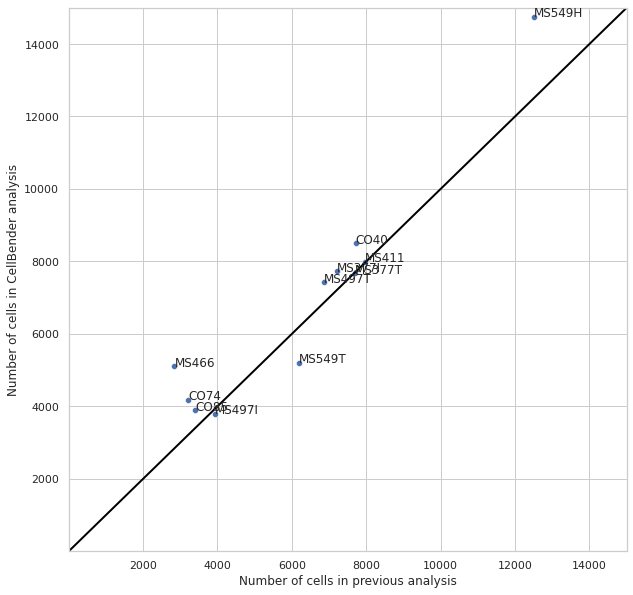

In [5]:
df = adata_prev.obs.sample_id.value_counts().to_frame().reset_index().rename(columns={"count": "n_previous"}).merge(
    adata_cellbender.obs.sample_id.value_counts().to_frame().reset_index().rename(columns={"count": "n_cellbender"}),
    on="sample_id", how="outer"
)
# scatterploot of n_previous vs n_cellbender using seaborn and include diagonal line in plot
# also add labels to the points and make the plot much bigger
# and save the figure to the plot_out folder
plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
plt.plot([0, 15000], [0, 15000], linewidth=2, color="black")
sns.scatterplot(data=df, x="n_previous", y="n_cellbender")
for i, row in df.iterrows():
    plt.text(row["n_previous"], row["n_cellbender"], row["sample_id"])
plt.xlabel("Number of cells in previous analysis")
plt.ylabel("Number of cells in CellBender analysis")
plt.xlim(1, 15000)
plt.ylim(1, 15000)
plt.savefig(plot_out / "sample_comparison_global.png", dpi=300)
plt.show()

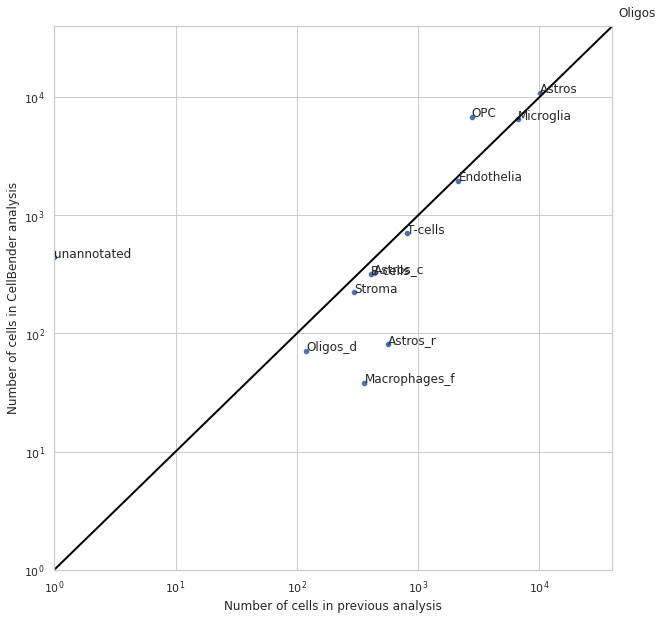

In [6]:
df = adata_prev.obs.cell_type.value_counts().to_frame().reset_index().rename(columns={"count": "n_previous"}).merge(
    adata_cellbender.obs.cell_type.value_counts().to_frame().reset_index().rename(columns={"count": "n_cellbender"}),
    on="cell_type", how="outer"
)
# replace NaNs with 1
df = df.fillna(1)
# scatterploot of n_previous vs n_cellbender using seaborn and include diagonal line in plot
# also add labels to the points and make the plot much bigger and make axis log log
plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
plt.plot([0, 40000], [0, 40000], linewidth=2, color="black")
sns.scatterplot(data=df, x="n_previous", y="n_cellbender")
for i, row in df.iterrows():
    plt.text(row["n_previous"], row["n_cellbender"], row["cell_type"])
plt.xlabel("Number of cells in previous analysis")
plt.ylabel("Number of cells in CellBender analysis")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1, 40000)
plt.ylim(1, 40000)
plt.savefig(plot_out / "celltype_comparison_global.png", dpi=300)
plt.show()

In [7]:
df_list = []
for smp in np.unique(adata_cellbender.obs.sample_id):
    cellbender_set = set(adata_cellbender.obs_names[adata_cellbender.obs.sample_id == smp])
    prev_set = set(adata_prev.obs_names[adata_prev.obs.sample_id == smp])
    df_list.append(pd.DataFrame({"sample_id": smp, "both": len(cellbender_set.intersection(prev_set)), "cellbender_only": len(cellbender_set.difference(prev_set)), "previous_only": len(prev_set.difference(cellbender_set))}, index=[0]))
df = pd.concat(df_list)
df = df.melt(id_vars="sample_id", var_name="comparison", value_name="count")
#df

/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /home/philipp/Work/VisiumMS/scripts/process/../../out/cellbender_comparison/sample_comparison_boxplot.png


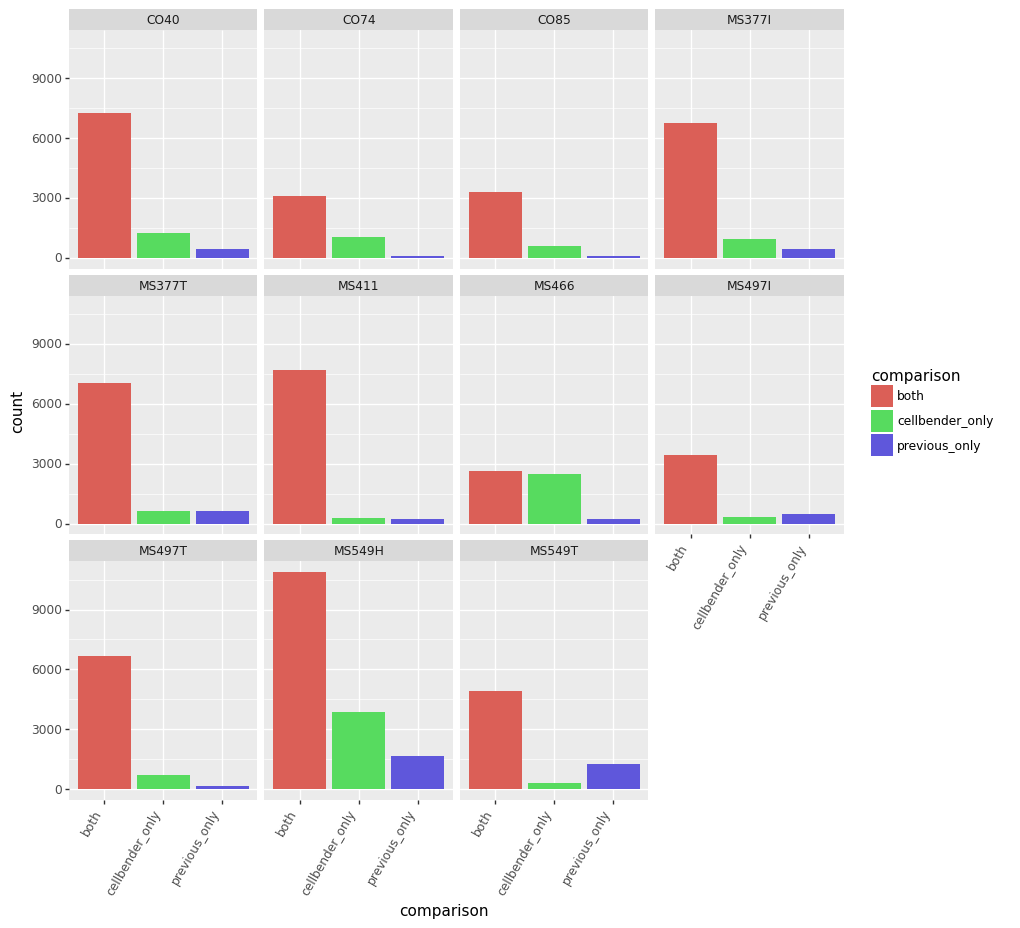

<ggplot: (8733334250487)>

In [8]:
plot = pn.ggplot(df,
          pn.aes(x= "comparison", y="count", fill="comparison")) + \
          pn.geom_bar(stat="identity") + \
          pn.facet_wrap("sample_id") + \
          pn.theme(axis_text_x=pn.element_text(rotation=60, hjust=1)) + \
          pn.theme(figure_size=(10, 10)) 

# save the plot
plot.save(plot_out / "sample_comparison_boxplot.png", dpi=300)

# show the plot
plot
            

In [9]:
df_list = []
for ct in np.unique(adata_cellbender.obs.cell_type):
    cellbender_set = set(adata_cellbender.obs_names[adata_cellbender.obs.cell_type == ct])
    prev_set = set(adata_prev.obs_names[adata_prev.obs.cell_type == ct])
    df_list.append(pd.DataFrame({"cell_type": ct, "both": len(cellbender_set.intersection(prev_set)), "cellbender_only": len(cellbender_set.difference(prev_set)), "previous_only": len(prev_set.difference(cellbender_set))}, index=[0]))
df = pd.concat(df_list)
df = df.melt(id_vars="cell_type", var_name="comparison", value_name="count")
#df

/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /home/philipp/Work/VisiumMS/scripts/process/../../out/cellbender_comparison/celltype_comparison_boxplot.png
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you n

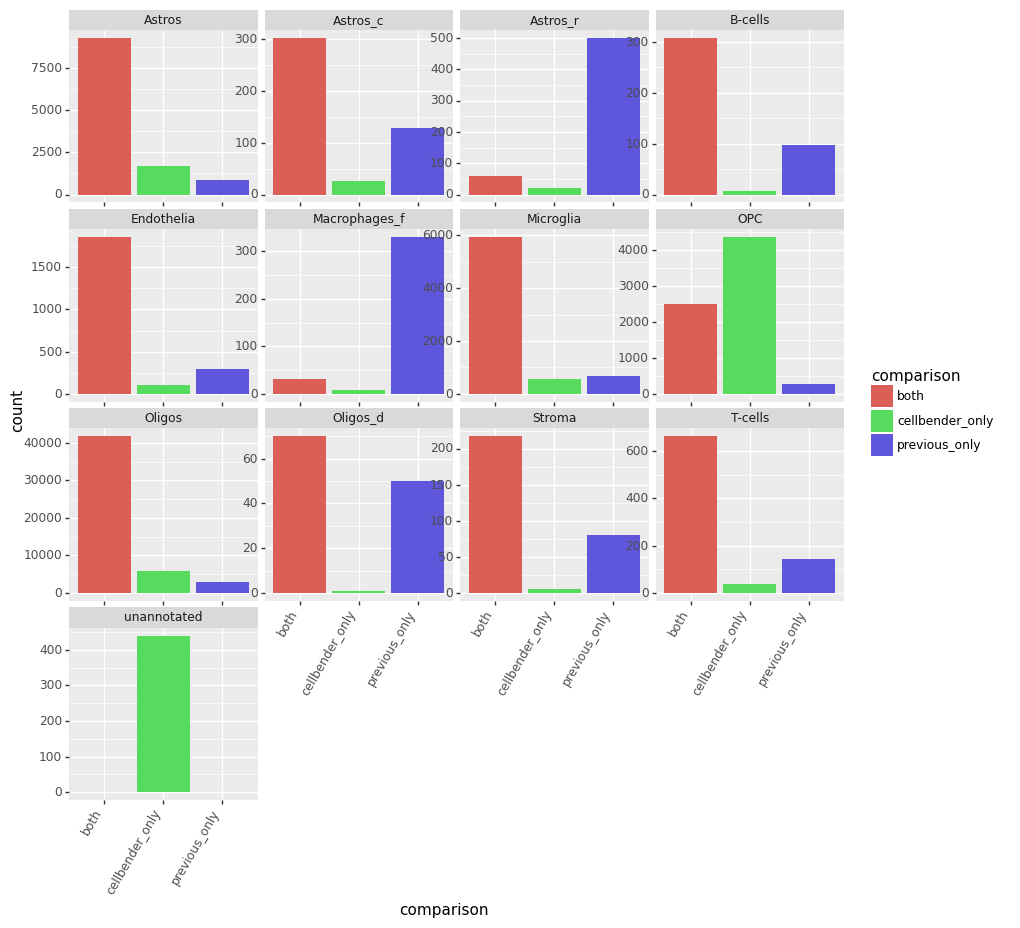

<ggplot: (8733331693011)>

In [10]:
plot = pn.ggplot(df,
          pn.aes(x= "comparison", y="count", fill="comparison")) + \
          pn.geom_bar(stat="identity") + \
          pn.facet_wrap("cell_type", scales="free") + \
          pn.theme(axis_text_x=pn.element_text(rotation=60, hjust=1)) + \
          pn.theme(figure_size=(10, 10)) 

# save the plot
plot.save(plot_out / "celltype_comparison_boxplot.png", dpi=300)

# show the plot
plot

# Compare to aggressive cell bender annotation

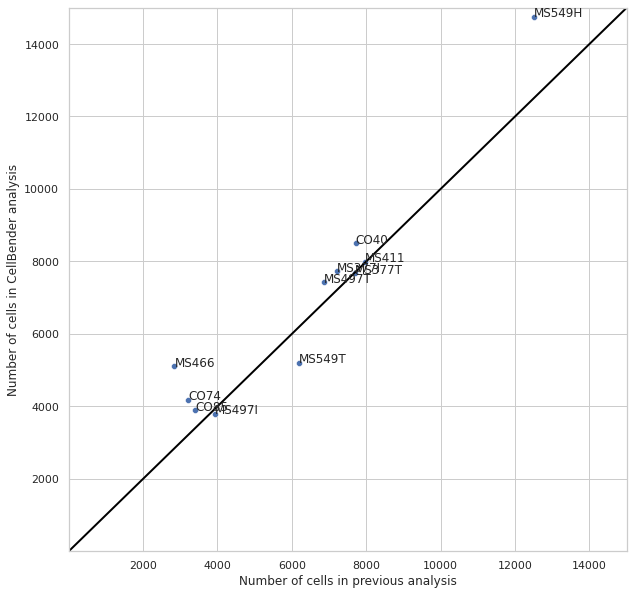

In [11]:
df = adata_prev.obs.sample_id.value_counts().to_frame().reset_index().rename(columns={"count": "n_previous"}).merge(
    adata_cellbender_forced.obs.sample_id.value_counts().to_frame().reset_index().rename(columns={"count": "n_cellbender"}),
    on="sample_id", how="outer"
)
# scatterploot of n_previous vs n_cellbender using seaborn and include diagonal line in plot
# also add labels to the points and make the plot much bigger
# and save the figure to the plot_out folder
plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
plt.plot([0, 15000], [0, 15000], linewidth=2, color="black")
sns.scatterplot(data=df, x="n_previous", y="n_cellbender")
for i, row in df.iterrows():
    plt.text(row["n_previous"], row["n_cellbender"], row["sample_id"])
plt.xlabel("Number of cells in previous analysis")
plt.ylabel("Number of cells in CellBender analysis")
plt.xlim(1, 15000)
plt.ylim(1, 15000)
plt.savefig(plot_out / "sample_comparison_global_forced.png", dpi=300)
plt.show()

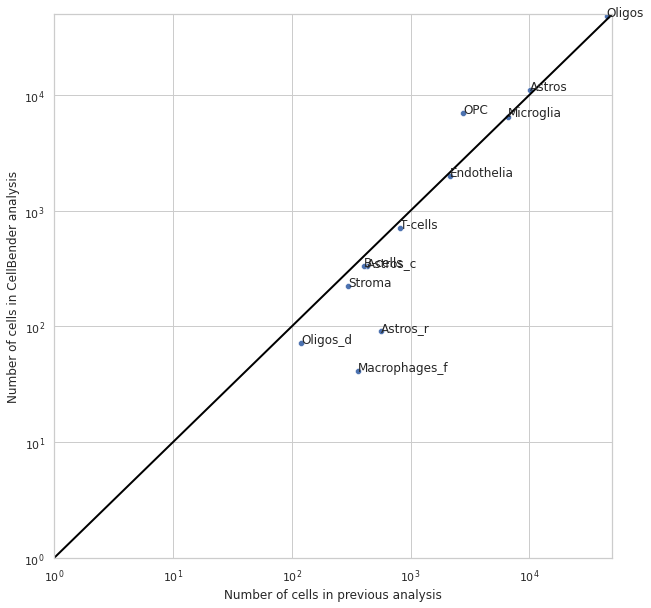

In [12]:
df = adata_prev.obs.cell_type.value_counts().to_frame().reset_index().rename(columns={"count": "n_previous"}).merge(
    adata_cellbender_forced.obs.cell_type.value_counts().to_frame().reset_index().rename(columns={"count": "n_cellbender"}),
    on="cell_type", how="outer"
)
# scatterploot of n_previous vs n_cellbender using seaborn and include diagonal line in plot
# also add labels to the points and make the plot much bigger and make axis log log
plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
plt.plot([0, 50000], [0, 50000], linewidth=2, color="black")
sns.scatterplot(data=df, x="n_previous", y="n_cellbender")
for i, row in df.iterrows():
    plt.text(row["n_previous"], row["n_cellbender"], row["cell_type"])
plt.xlabel("Number of cells in previous analysis")
plt.ylabel("Number of cells in CellBender analysis")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1, 50000)
plt.ylim(1, 50000)
plt.savefig(plot_out / "celltype_comparison_global_forced.png", dpi=300)
plt.show()

In [13]:
df_list = []
for smp in np.unique(adata_cellbender_forced.obs.sample_id):
    cellbender_set = set(adata_cellbender_forced.obs_names[adata_cellbender_forced.obs.sample_id == smp])
    prev_set = set(adata_prev.obs_names[adata_prev.obs.sample_id == smp])
    df_list.append(pd.DataFrame({"sample_id": smp, "both": len(cellbender_set.intersection(prev_set)), "cellbender_only": len(cellbender_set.difference(prev_set)), "previous_only": len(prev_set.difference(cellbender_set))}, index=[0]))
df = pd.concat(df_list)
df = df.melt(id_vars="sample_id", var_name="comparison", value_name="count")
#df

/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /home/philipp/Work/VisiumMS/scripts/process/../../out/cellbender_comparison/sample_comparison_boxplot_forced.png


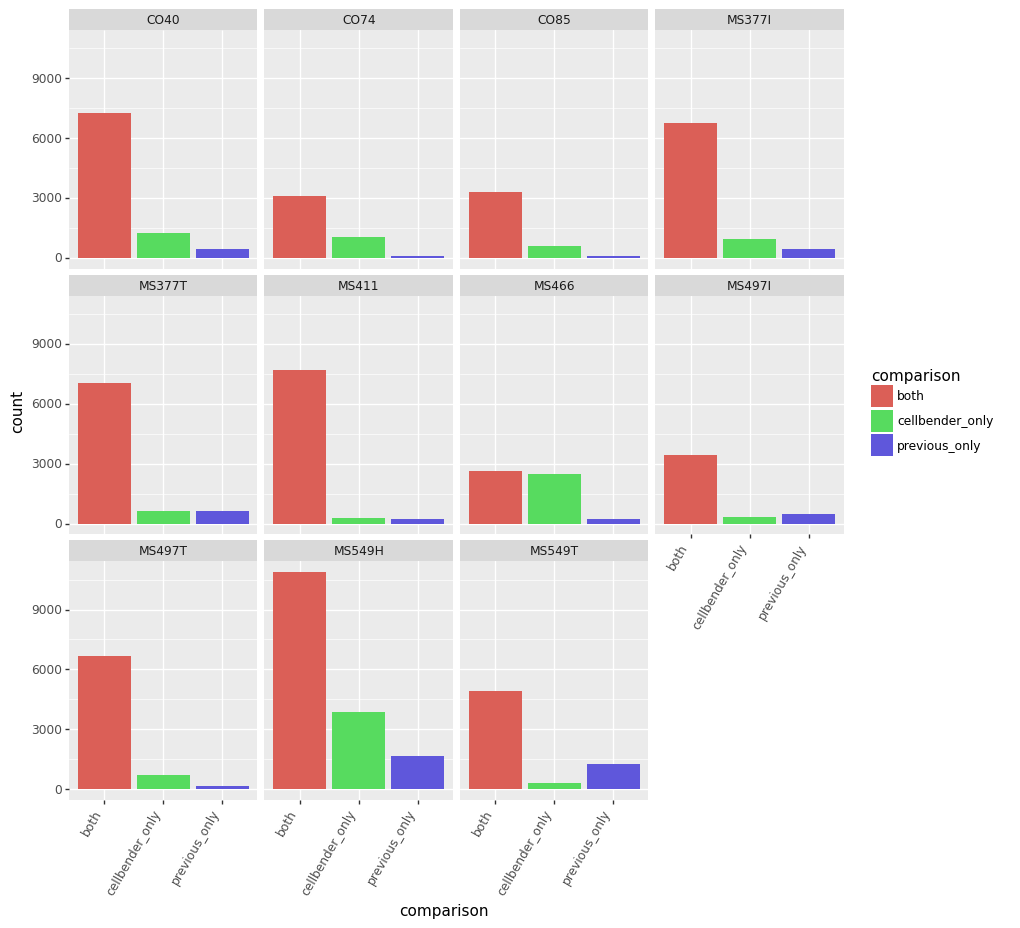

<ggplot: (8733326835294)>

In [14]:
plot = pn.ggplot(df,
          pn.aes(x= "comparison", y="count", fill="comparison")) + \
          pn.geom_bar(stat="identity") + \
          pn.facet_wrap("sample_id") + \
          pn.theme(axis_text_x=pn.element_text(rotation=60, hjust=1)) + \
          pn.theme(figure_size=(10, 10)) 

# save the plot
plot.save(plot_out / "sample_comparison_boxplot_forced.png", dpi=300)

# show the plot
plot
            

In [15]:
df_list = []
for ct in np.unique(adata_cellbender_forced.obs.cell_type):
    cellbender_set = set(adata_cellbender_forced.obs_names[adata_cellbender_forced.obs.cell_type == ct])
    prev_set = set(adata_prev.obs_names[adata_prev.obs.cell_type == ct])
    df_list.append(pd.DataFrame({"cell_type": ct, "both": len(cellbender_set.intersection(prev_set)), "cellbender_only": len(cellbender_set.difference(prev_set)), "previous_only": len(prev_set.difference(cellbender_set))}, index=[0]))
df = pd.concat(df_list)
df = df.melt(id_vars="cell_type", var_name="comparison", value_name="count")
#df

/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /home/philipp/Work/VisiumMS/scripts/process/../../out/cellbender_comparison/celltype_comparison_boxplot_forced.png
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: I

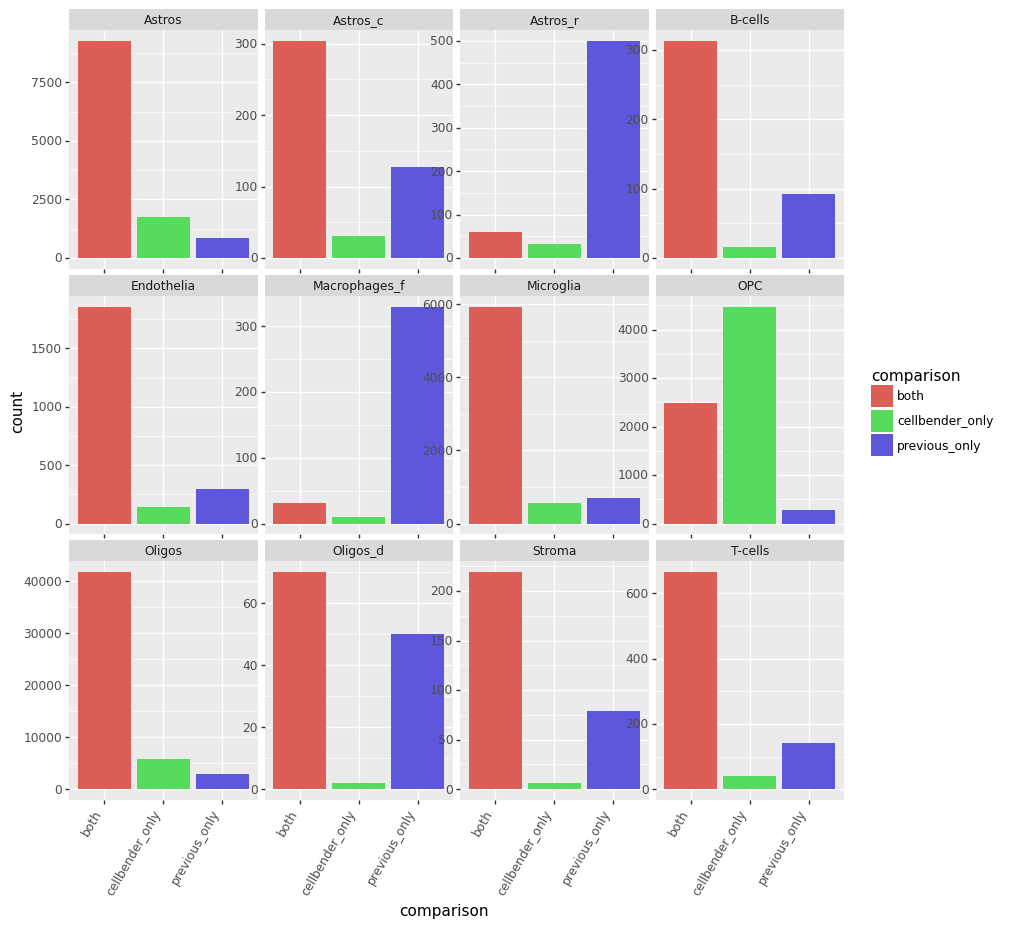

<ggplot: (8733326811694)>

In [16]:
plot = pn.ggplot(df,
          pn.aes(x= "comparison", y="count", fill="comparison")) + \
          pn.geom_bar(stat="identity") + \
          pn.facet_wrap("cell_type", scales="free") + \
          pn.theme(axis_text_x=pn.element_text(rotation=60, hjust=1)) + \
          pn.theme(figure_size=(10, 10)) 

# save the plot
plot.save(plot_out / "celltype_comparison_boxplot_forced.png", dpi=300)

# show the plot
plot

# Comparison to unfiltered cell bender

In [20]:
adata_cellbender_noqc = {sample: sc.read_10x_h5(cellbender_out / sample / "cell_bender_matrix_filtered.h5") for sample in samples}
for sample in samples:
    adata_cellbender_noqc[sample].obs.index = np.array([sample + barcode for barcode in adata_cellbender_noqc[sample].obs.index])
adata_cellbender_noqc = sc.concat(list(adata_cellbender_noqc.values()), join="outer", label="sample_id", keys=list(adata_cellbender_noqc.keys()))

/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/minico

InvalidIndexError: Reindexing only valid with uniquely valued Index objects